In [110]:
using Revise
using EAMC
using Plots
using LinearAlgebra

# utility functions
cg = cgrad(:matter, scale=:exp)
cg.colors[1] = colorant"white"
cg.values[1] = 0
cg.values[2]=eps()
#cg.values[2] =cg.values[3]/2
hm(x; kwargs...) = heatmap(x|>collect, yflip=true, color = cg; kwargs...)

hm (generic function with 1 method)

In [111]:
# experiment setup

beta = 2

nt = 10
tmax = 20
ts = range(0, tmax, length=nt+1)

nx = 20
xmax = 1.5
xs = range(-xmax,xmax, length=nx)


process = EAMC.OverdampedLangevin(
    V = (x,t) -> beta * (x^2-1)^2,
    phi = 1,
    grid = xs)

qs = [EAMC.generatormatrix(process, t) for t in ts];

In [112]:
g = galerkin(qs, ts);

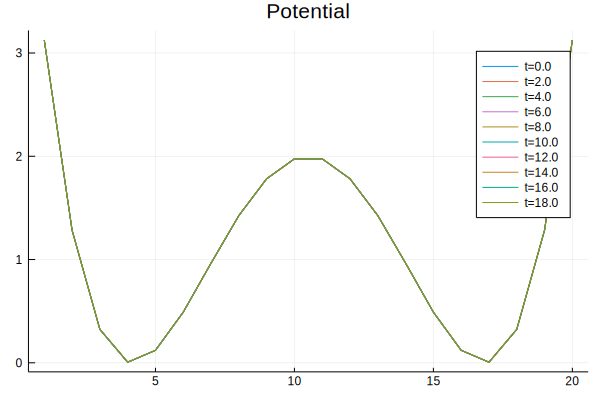

In [113]:
p=plot(title="Potential")
for t in ts[1:end-1]
    plot!(process.V.(process.grid,t),label="t=$(round(t, digits=2))")
end
p

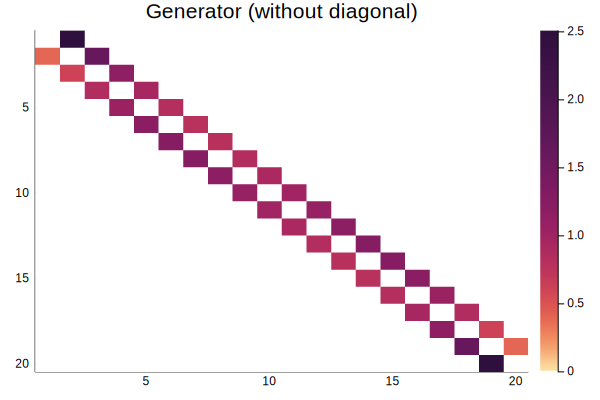

In [114]:
hm(qs[1]-Diagonal(qs[1]), title="Generator (without diagonal)")

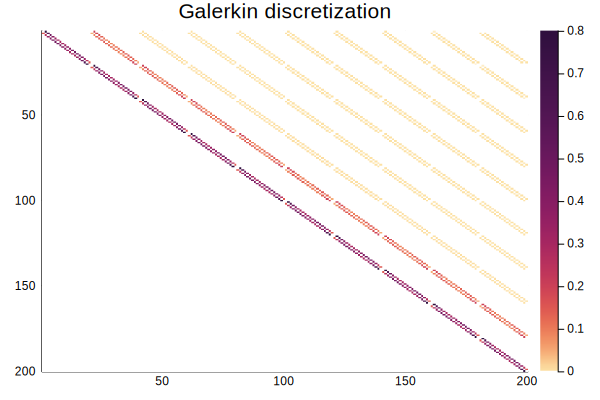

In [129]:
p=hm(g, color=cg, title="Galerkin discretization")
savefig("dw_galerkin.pdf")
p

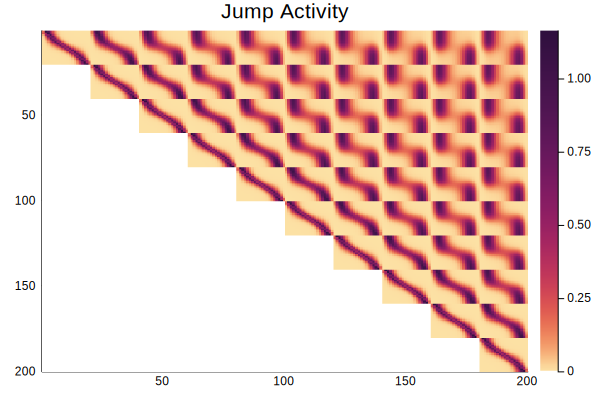

In [127]:
E = EAMC.jumpactivity(g)
hm(E, title="Jump Activity") |> display
savefig("dw_activity.pdf")

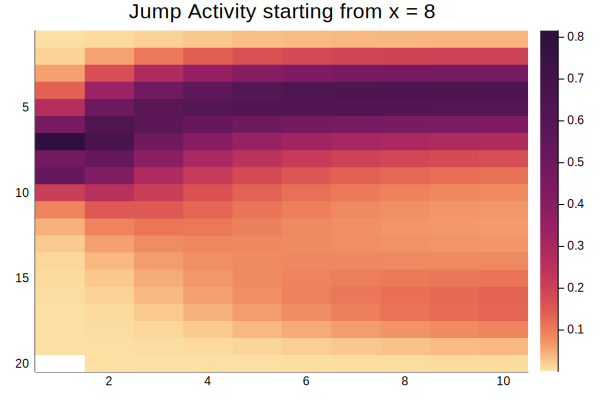

In [117]:
f0=zeros(nx)
x0 = 8
f0[x0] = 1
act = EAMC.project_jumpactivity(E, f0)
hm(act, title="Jump Activity starting from x = $x0")

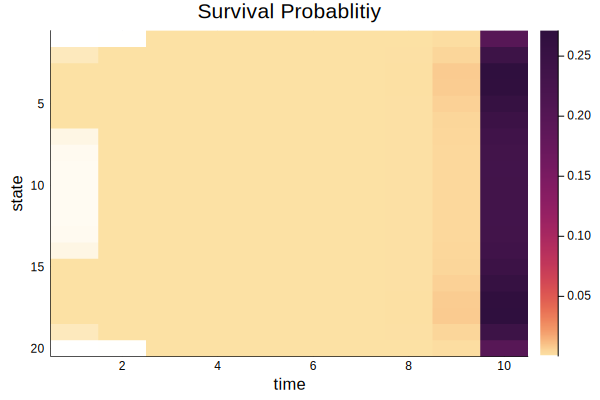

In [118]:
#survival from inside each timecell to T
qout = [collect(-diag(q)) for q in qs]
q = qout[1]
i = 4
S=zeros(nx, nt)
for i=1:nt
    S[:,i] .= 1 ./ q .*(exp.(-q*(ts[end] - ts[i+1])) - exp.(-q*(ts[end] - ts[i]))) / (ts[i+1]-ts[i])
end
hm(S, title="Survival Probablitiy", xlabel="time", ylabel="state")

In [119]:
Pf = EAMC.perronfrobenius(g, qs, ts)

20×20 Adjoint{Float64,Array{Float64,2}}:
 0.00988285   0.0098445   0.00977885   …  0.00026116  0.000247343
 0.0620057    0.0617778   0.061385        0.00175271  0.00166298 
 0.160847     0.160299    0.159353        0.00503717  0.00479155 
 0.218718     0.218059    0.216905        0.00797901  0.00761906 
 0.191484     0.191013    0.190175        0.00881749  0.00846411 
 0.128314     0.128103    0.12771      …  0.00834205  0.00806262 
 0.0755826    0.0755464   0.0754604       0.00788095  0.00767342 
 0.0433385    0.0433888   0.0434567       0.00809324  0.00793458 
 0.0258489    0.0259351   0.026071        0.00927489  0.00914448 
 0.0166283    0.0167309   0.0168984       0.0118429   0.0117289  
 0.0117289    0.0118429   0.0120343    …  0.0167309   0.0166283  
 0.00914448   0.00927489  0.0094979       0.0259351   0.0258489  
 0.00793458   0.00809324  0.00837011      0.0433888   0.0433385  
 0.00767342   0.00788095  0.00824862      0.0755464   0.0755826  
 0.00806262   0.00834205  0.0088449

In [11]:
Pf_exp = exp(qs[1]|>collect)'

20×20 Adjoint{Float64,Array{Float64,2}}:
 0.139263     0.0593403    0.0195819    …  8.76192e-18  1.12419e-18
 0.374015     0.292611     0.144276        4.09169e-16  5.52254e-17
 0.322411     0.376886     0.370713        1.13011e-14  1.61144e-15
 0.128653     0.199818     0.306685        2.10257e-13  3.17994e-14
 0.0300765    0.0581422    0.122156        2.95075e-12  4.75114e-13
 0.00488081   0.0112832    0.0301802    …  3.4221e-11   5.88866e-12
 0.000623978  0.00167949   0.00546843      3.52201e-10  6.50439e-11
 6.90341e-5   0.000212219  0.000815926     3.39178e-9   6.75561e-10
 7.07074e-6   2.44619e-5   0.000108616     3.16889e-8   6.84672e-9 
 7.01457e-7   2.6989e-6    1.36046e-5      2.93153e-7   6.91841e-8 
 6.91841e-8   2.93153e-7   1.65485e-6   …  2.6989e-6    7.01457e-7 
 6.84672e-9   3.16889e-8   1.9811e-7       2.44619e-5   7.07074e-6 
 6.75561e-10  3.39178e-9   2.32704e-8      0.000212219  6.90341e-5 
 6.50439e-11  3.52201e-10  2.632e-9        0.00167949   0.000623978
 5.8886

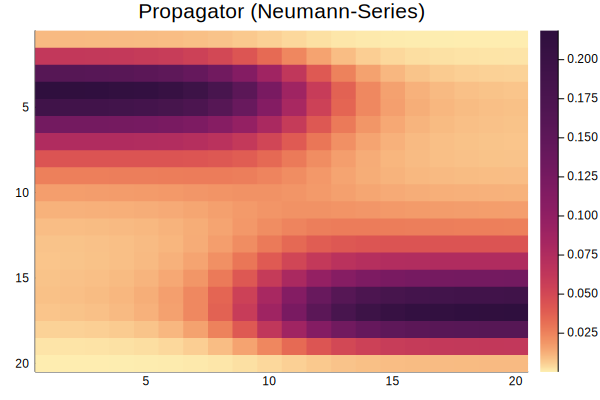

In [12]:
hm(Pf, title="Propagator (Neumann-Series)")

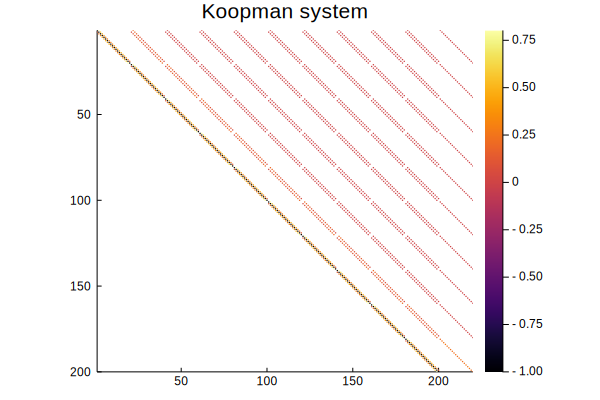

In [13]:
A = EAMC.koopman_system(g, nx)
spy(A, title="Koopman system")

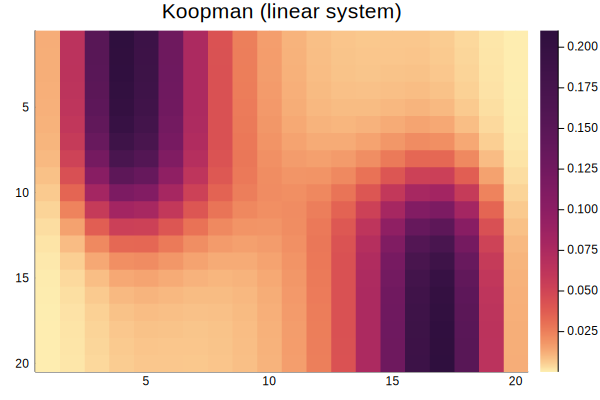

In [14]:
K = EAMC.koopman(g, nx)
hm(K, title="Koopman (linear system)")

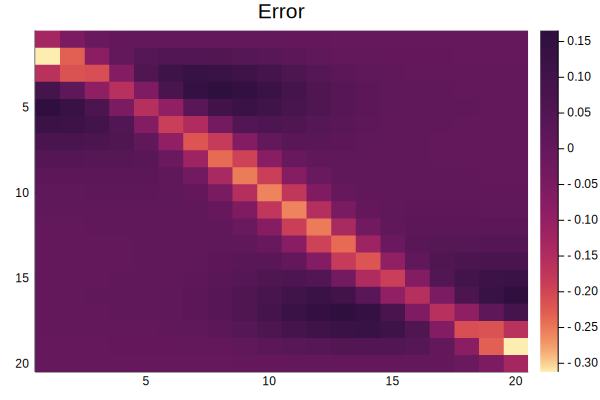

In [15]:
hm(Pf - Pf_exp, title="Error")